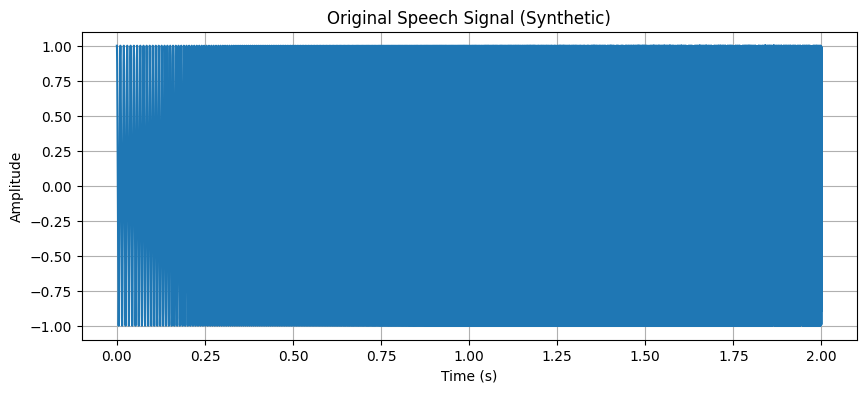

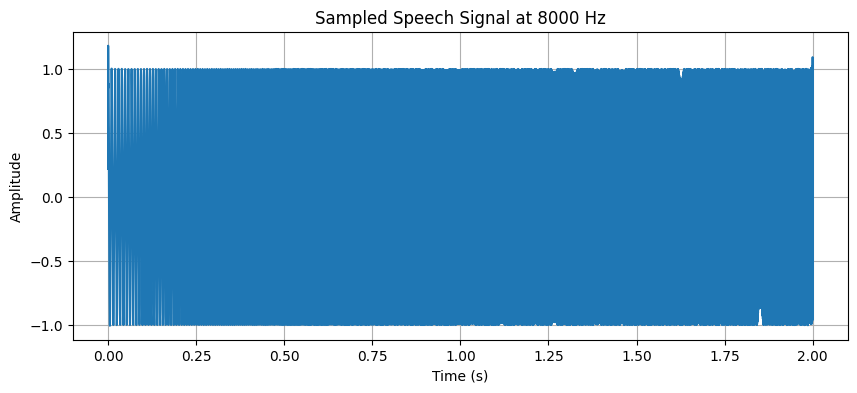

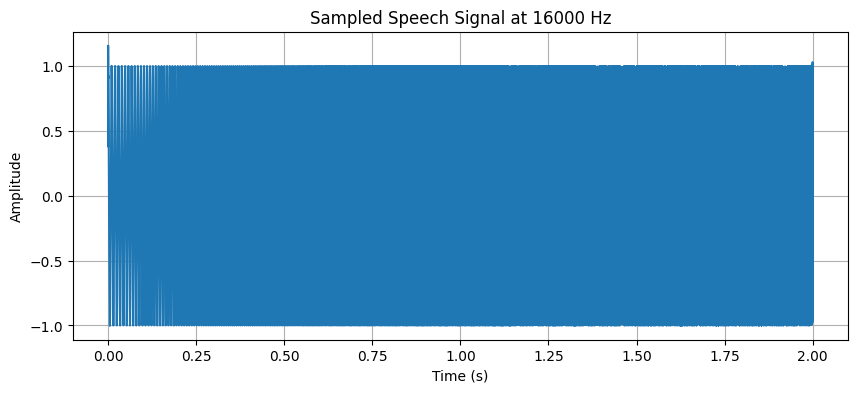

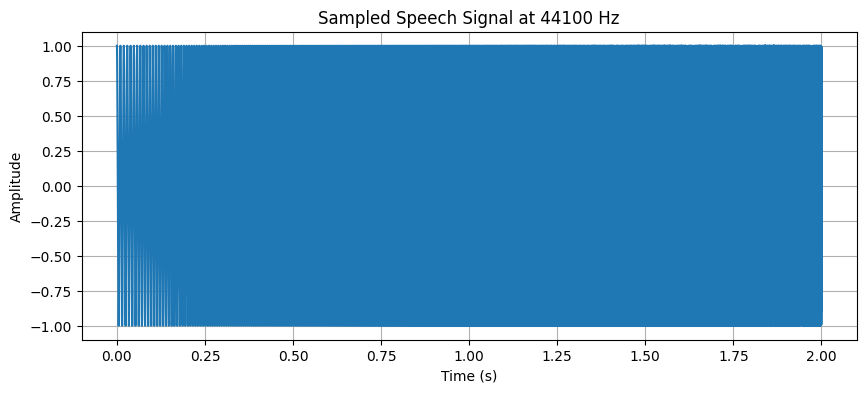

Mean Squared Error (MSE) Results for Part 1:
At 8000 Hz - ZOH MSE: 0.952904, Linear MSE: 0.001986
At 16000 Hz - ZOH MSE: 1.008527, Linear MSE: 0.000140
At 44100 Hz - ZOH MSE: 0.000000, Linear MSE: 0.000000

Inference for Part 1:
Higher sampling rates (e.g., 44.1 kHz) result in lower MSE and better reconstruction quality, closely matching the original signal. Lower rates (e.g., 8 kHz) introduce more aliasing and distortion, leading to higher MSE. Linear interpolation generally performs better than zero-order hold, as it provides smoother transitions between samples, reducing reconstruction errors.


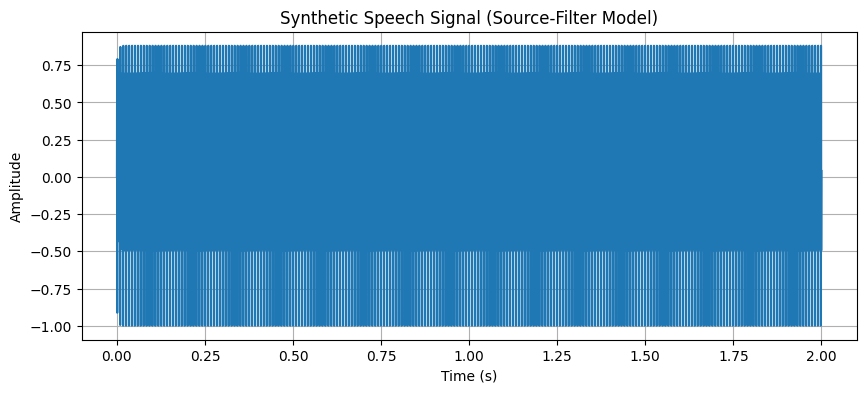


Analysis for Part 2 (b):
The filter models the vocal tract by introducing resonances (formants), shaping the flat spectrum of the source (impulse train) into a speech-like signal with peaks at formant frequencies. This transforms the buzzy source into a more natural vowel sound.

Mean Squared Error (MSE) Results for Part 2:
At 8000 Hz - MSE: 0.000197
At 16000 Hz - MSE: 0.000013
At 44100 Hz - MSE: 0.000000

Inference for Part 2:
The source-filter model effectively synthesizes speech by combining a excitation source with a vocal tract filter. Higher sampling rates preserve the formant structure and reduce reconstruction errors (lower MSE). Lower rates may alias high-frequency formants, degrading quality. Reconstruction via linear interpolation helps mitigate some losses but cannot fully recover information lost during downsampling.


In [5]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# Part 1: Sampling and Reconstruction of Speech Signals

# (a) Generate a synthetic original speech-like signal (using chirp to simulate frequency variations in speech)
fs_original = 44100  # Original sampling rate in Hz
duration = 2  # Duration in seconds
t_original = np.arange(0, duration, 1/fs_original)
original_signal = signal.chirp(t_original, f0=100, t1=duration, f1=2000, method='logarithmic')

# Plot the time domain representation of the original speech signal
plt.figure(figsize=(10, 4))
plt.plot(t_original, original_signal)
plt.title('Original Speech Signal (Synthetic)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

# (b) & (c) Sample the speech signal at different sampling rates and plot
sampling_rates = [8000, 16000, 44100]
sampled_signals = {}

for fs in sampling_rates:
    # Resample to the new sampling rate
    num_samples = int(len(original_signal) * fs / fs_original)
    sampled_signal = signal.resample(original_signal, num_samples)
    t_sampled = np.linspace(0, duration, num_samples, endpoint=False)
    sampled_signals[fs] = (sampled_signal, t_sampled)

    # Plot sampled signal
    plt.figure(figsize=(10, 4))
    plt.plot(t_sampled, sampled_signal)
    plt.title(f'Sampled Speech Signal at {fs} Hz')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.grid(True)
    plt.show()

# (d) Reconstruct the signal using Zero-order hold and Linear interpolation
reconstructed_zoh = {}
reconstructed_linear = {}

for fs in sampling_rates:
    sampled_signal, t_sampled = sampled_signals[fs]

    # Zero-order hold (nearest-neighbor interpolation)
    # Find the step size
    hold_steps = int(fs_original / fs)
    zoh_signal = np.repeat(sampled_signal, hold_steps)
    # Trim or pad to match original length
    if len(zoh_signal) > len(original_signal):
        zoh_signal = zoh_signal[:len(original_signal)]
    elif len(zoh_signal) < len(original_signal):
        zoh_signal = np.pad(zoh_signal, (0, len(original_signal) - len(zoh_signal)), mode='edge')
    reconstructed_zoh[fs] = zoh_signal

    # Linear interpolation
    interpolator = interp1d(t_sampled, sampled_signal, kind='linear', fill_value='extrapolate')
    linear_signal = interpolator(t_original)
    reconstructed_linear[fs] = linear_signal

# (e) Calculate MSE for both methods
print("Mean Squared Error (MSE) Results for Part 1:")
for fs in sampling_rates:
    mse_zoh = np.mean((original_signal - reconstructed_zoh[fs]) ** 2)
    mse_linear = np.mean((original_signal - reconstructed_linear[fs]) ** 2)
    print(f'At {fs} Hz - ZOH MSE: {mse_zoh:.6f}, Linear MSE: {mse_linear:.6f}')

# Inference for Part 1 (printed as text)
print("\nInference for Part 1:")
print("Higher sampling rates (e.g., 44.1 kHz) result in lower MSE and better reconstruction quality, "
      "closely matching the original signal. Lower rates (e.g., 8 kHz) introduce more aliasing and distortion, "
      "leading to higher MSE. Linear interpolation generally performs better than zero-order hold, "
      "as it provides smoother transitions between samples, reducing reconstruction errors.")

# Part 2: Source-Filter Model

# (a) Generate a synthetic speech signal using the source-filter model
# (i) Create a source signal: glottal pulse train for voiced sound
pitch = 120  # Pitch frequency in Hz for voiced sound
period_samples = int(fs_original / pitch)
num_pulses = int(len(t_original) / period_samples) + 1
source_signal = np.zeros(len(t_original))
source_signal[::period_samples] = 1  # Impulse train

# (ii) Apply a filter modeling the vocal tract (all-pole filter with formants)
# Define formants for a simple vowel sound (e.g., /a/ with formants at 730 Hz, 1090 Hz)
def get_formant_coeffs(f, bw, fs):
    r = np.exp(-np.pi * bw / fs)
    theta = 2 * np.pi * f / fs
    a1 = -2 * r * np.cos(theta)
    a2 = r ** 2
    return [1, a1, a2]

formant1 = get_formant_coeffs(730, 80, fs_original)
formant2 = get_formant_coeffs(1090, 100, fs_original)
a_coeffs = signal.convolve(formant1, formant2)  # Combine formants by convolving coefficients

# Apply the filter (gain normalized roughly)
b_coeffs = [1.0]  # Numerator for all-pole is 1
synthetic_speech = signal.lfilter(b_coeffs, a_coeffs, source_signal)
# Normalize amplitude to match original signal's scale
synthetic_speech /= np.max(np.abs(synthetic_speech))  # Normalize to [-1, 1]

# (b) Plot the generated speech signal
plt.figure(figsize=(10, 4))
plt.plot(t_original, synthetic_speech)
plt.title('Synthetic Speech Signal (Source-Filter Model)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

# Analyze the effect (printed)
print("\nAnalysis for Part 2 (b):")
print("The filter models the vocal tract by introducing resonances (formants), shaping the flat spectrum "
      "of the source (impulse train) into a speech-like signal with peaks at formant frequencies. "
      "This transforms the buzzy source into a more natural vowel sound.")

# (c) Sample the synthetic speech at different rates
sampled_synthetic = {}
for fs in sampling_rates:
    num_samples = int(len(synthetic_speech) * fs / fs_original)
    sampled_signal = signal.resample(synthetic_speech, num_samples)
    t_sampled = np.linspace(0, duration, num_samples, endpoint=False)
    sampled_synthetic[fs] = (sampled_signal, t_sampled)

# (d) Reconstruct using linear interpolation (as an example)
reconstructed_synthetic = {}
for fs in sampling_rates:
    sampled_signal, t_sampled = sampled_synthetic[fs]
    interpolator = interp1d(t_sampled, sampled_signal, kind='linear', fill_value='extrapolate')
    recon_signal = interpolator(t_original)
    reconstructed_synthetic[fs] = recon_signal

# (e) Compute MSE
print("\nMean Squared Error (MSE) Results for Part 2:")
for fs in sampling_rates:
    mse = np.mean((synthetic_speech - reconstructed_synthetic[fs]) ** 2)
    print(f'At {fs} Hz - MSE: {mse:.6f}')

# Inference for Part 2 (printed as text)
print("\nInference for Part 2:")
print("The source-filter model effectively synthesizes speech by combining a excitation source with a vocal tract filter. "
      "Higher sampling rates preserve the formant structure and reduce reconstruction errors (lower MSE). "
      "Lower rates may alias high-frequency formants, degrading quality. Reconstruction via linear interpolation "
      "helps mitigate some losses but cannot fully recover information lost during downsampling.")